## Introduccion

Este block de notas muestra un nuevo modelo muy similar al 2. La unica diferencia es que se filtran los outliers basándonos en la mtriz scattler del modelo 2.

Para empezar importamos los modulos de Python a utilizar:

In [14]:
import numpy  as np  
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Lectura de los datos de train y test
train_data = pd.read_csv('./data/data_train.csv', sep=';', decimal='.')
test_data = pd.read_csv('./data/data_test.csv', sep=';', decimal='.')

# Nos qquedamos con las variables de interes para la pregunta
variables_seleccionadas = ['Price', 'Bathrooms', 'Bedrooms', 'Beds', 'Review Scores Rating',
                                'Neighbourhood', 'City']
train_data = train_data.filter(variables_seleccionadas)
test_data = test_data.filter(variables_seleccionadas)

# Convertimos variables categoricas a numericas en caso de existir
from sklearn import preprocessing

for variable in [key for key in dict(train_data.dtypes) if dict(train_data.dtypes)[key] in ['object']]:
    le_last_scraped	 = preprocessing.LabelEncoder()
    le_last_scraped.fit(train_data[variable])
    train_data['le_' + variable] = le_last_scraped.transform(train_data[variable])
    train_data = train_data.drop(variable, axis='columns')

for variable in [key for key in dict(test_data.dtypes) if dict(test_data.dtypes)[key] in ['object']]:
    le_last_scraped_1 = preprocessing.LabelEncoder()
    le_last_scraped_1.fit(test_data[variable])
    test_data['le_' + variable] = le_last_scraped_1.transform(test_data[variable])
    test_data = test_data.drop(variable, axis='columns')

# Eliminamos nan e infinitos del dataset
variables = ['Bathrooms', 'Bedrooms', 'Beds', 'Price', 'Review Scores Rating']
for variable in variables:
    train_data[variable].fillna(train_data[variable].mode()[0], inplace=True)
    test_data[variable].fillna(test_data[variable].mode()[0], inplace=True)

test_data = test_data[np.isfinite(test_data).all(1)]

# Fitro de los datos de entrenamiento por precio
train_data = train_data.loc[train_data['Price'] <= 350]

train_data = train_data.loc[train_data['Bathrooms'] <= 4]
train_data = train_data.loc[train_data['Bedrooms'] <= 5]
train_data = train_data.loc[train_data['Beds'] <= 10]
train_data = train_data.loc[train_data['Review Scores Rating'] > 70]
train_data = train_data.loc[train_data['le_City'] >= 50]
train_data = train_data.loc[train_data['le_City'] <= 150]

train_data.head(5).T


,0,1,2,3,4
Price,60.0,50.0,10.0,30.0,32.0
Bathrooms,1.0,1.0,1.5,3.0,1.0
Bedrooms,1.0,1.0,1.0,1.0,1.0
Beds,2.0,2.0,8.0,1.0,1.0
Review Scores Rating,95.0,91.0,100.0,100.0,92.0
le_Neighbourhood,150.0,351.0,46.0,351.0,115.0
le_City,106.0,106.0,106.0,106.0,106.0


Ahora preparamos los datos para realizar el estudio de regresion

In [15]:
from sklearn import preprocessing

# Dataset de train
data_train = train_data.values
y_train = data_train[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data_train[:,1:]      # nos quedamos con el resto

# Dataset de test
data_test = test_data.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto


In [16]:

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test)

print('Datos entrenamiento: ', XtrainScaled.shape)
print('Datos test: ', XtestScaled.shape)

Datos entrenamiento:  (10651, 6)
Datos test:  (2956, 6)


Ahora observamos la relacion entre las variables del modelo/problema.

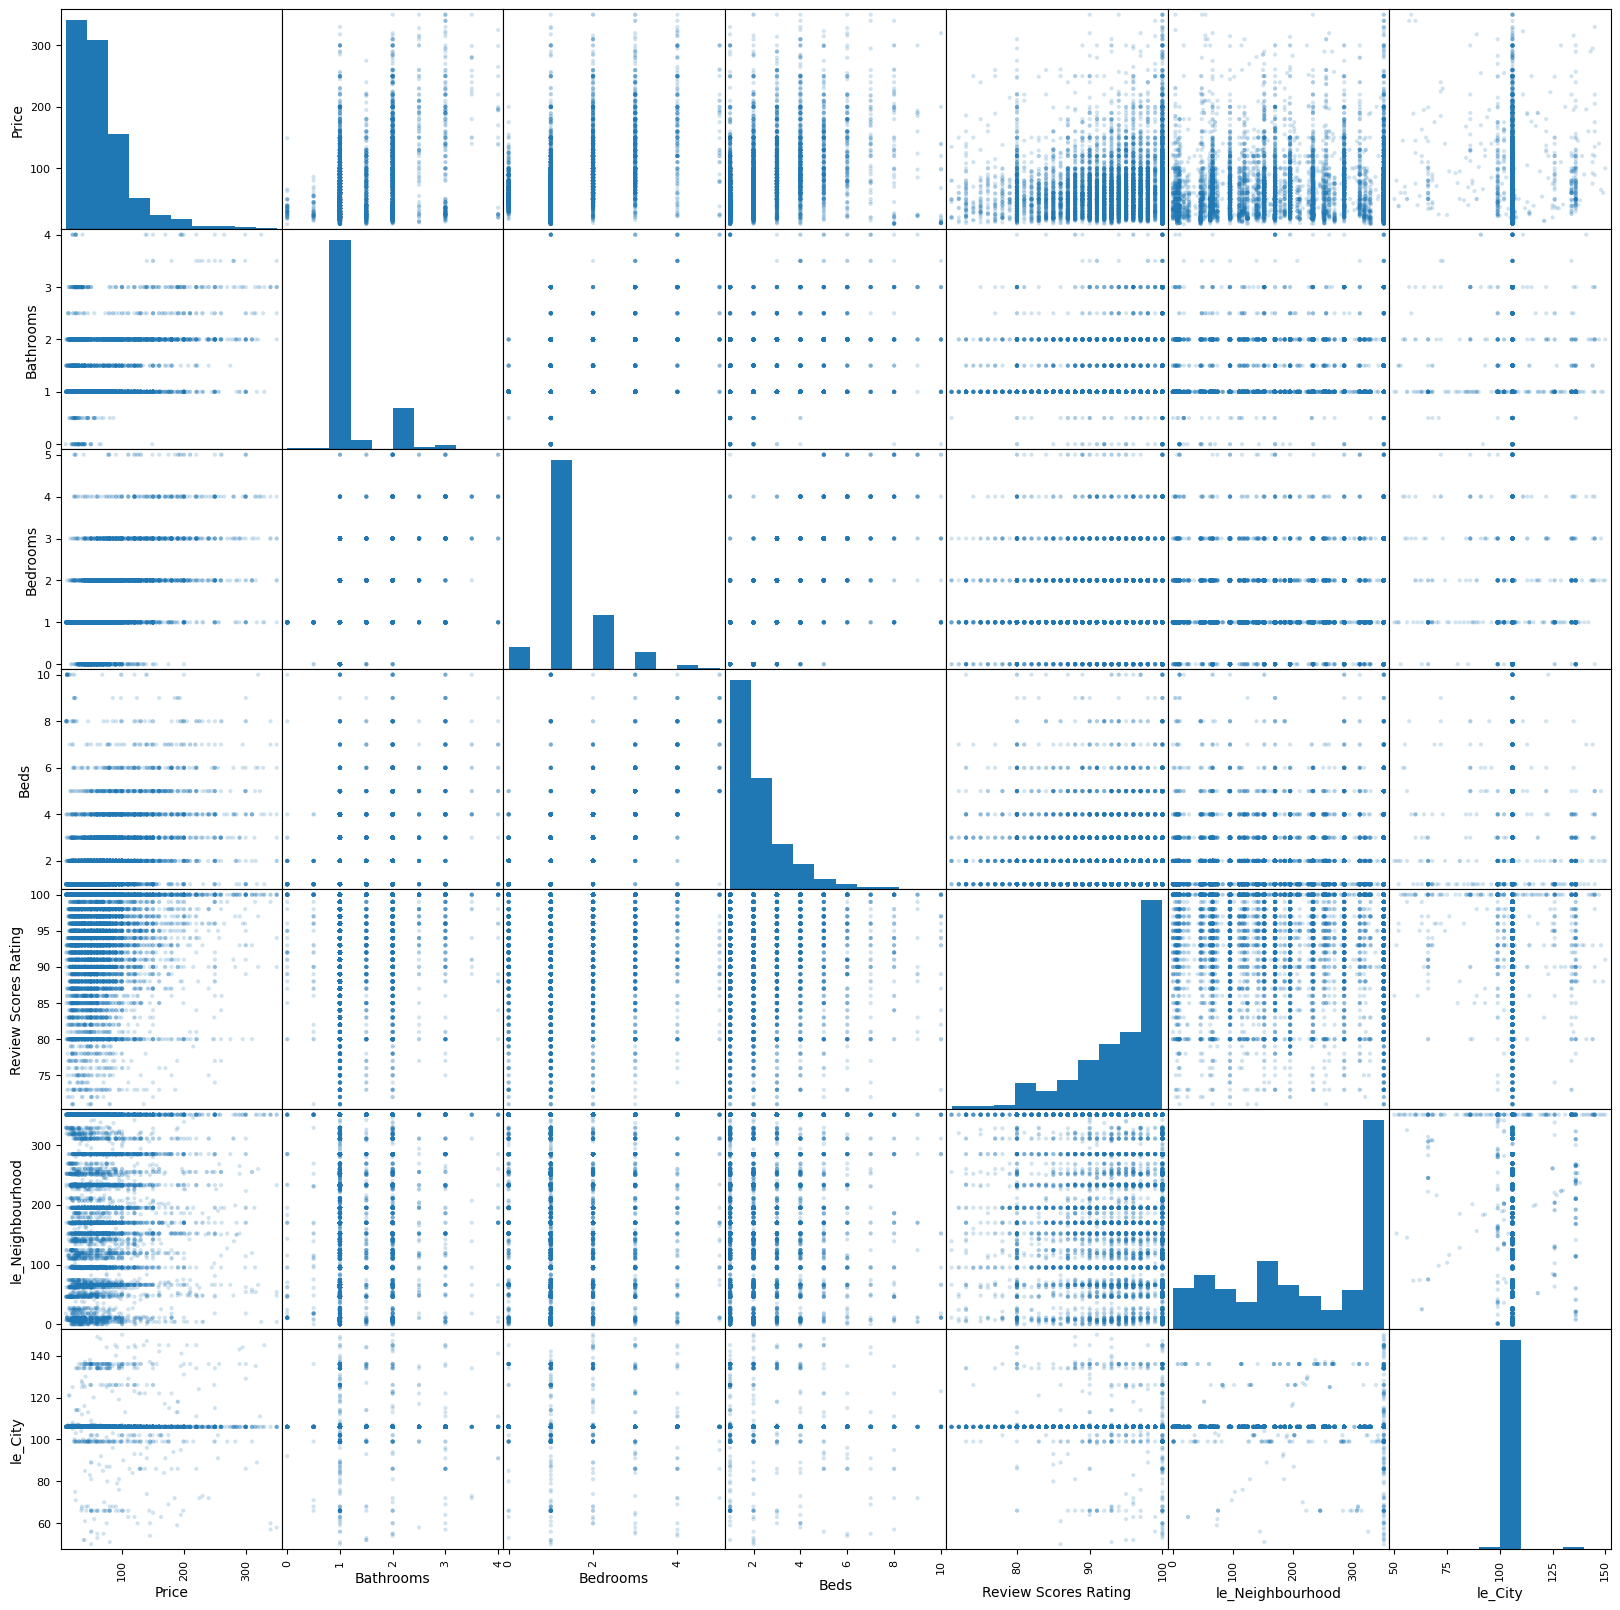

In [17]:
pd.plotting.scatter_matrix(train_data, alpha=0.2, figsize=(20, 20), diagonal = 'hist')
plt.show()

Como en el caso anterior buscamos el valor de _alfa_ óptimo.

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................alpha=0.37926901907322497; total time=   0.0s
[CV] END ..........................alpha=0.37926901907322497; total time=   0.0s
[CV] END ..........................alpha=0.37926901907322497; total time=   0.0s
[CV] END ............................alpha=1.438449888287663; total time=   0.0s
[CV] END ............................alpha=1.438449888287663; total time=   0.0s
[CV] END ............................alpha=1.438449888287663; total time=   0.0s
[CV] END .............................alpha=5.45559478116852; total time=   0.0s
[CV] END .............................alpha=5.45559478116852; total time=   0.0s
[CV] END .............................alpha=5.45

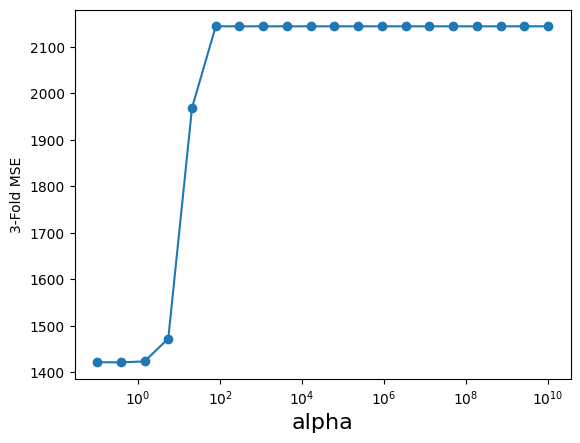

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-1,10,20)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 3, verbose=2)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('3-Fold MSE')
plt.show()

En este caso el valor de _alfa_ óptimo es diferente de los dos modelos anteriores e igual a 0.37926901907322497.

In [19]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

feature_names = train_data.columns[1:] # es igual en train y en test

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 1.41e+03
MSE Modelo Lasso (test) : 3.96e+03
RMSE Modelo Lasso (train): 37.6
RMSE Modelo Lasso (test) : 62.9
Bathrooms 6.315642227342459
Bedrooms 13.61022684703485
Beds 11.386464963011305
Review Scores Rating 2.9848701176045576
le_Neighbourhood -0.19774814664437707
le_City 0.5203367966264902


Como era de esperar Lasso no ha podido identificar variables para ignorar.

Ahora compararemos los errores de los 3 modelos:

| Error | Primer modelo | Modelo nuevo | Modelo nuevo sin outliers |
| --- | --- | --- | --- |
| MSE Modelo Lasso (train) | 2.67e+03 | 1.67e+03 | 1.41e+03 |
| MSE Modelo Lasso (test) | 5.83e+03 | 3.91e+03 | 3.96e+03 |
| RMSE Modelo Lasso (train) | 51.7 | 40.9 | 37.6 |
| RMSE Modelo Lasso (test) | 76.3 | 62.5 | 62.9 |


Efectivamente el modelo 3 no es mejor en terminos de errores de test,  mejora los errores de train, lo que significa un modelo con signos overfitting, es decir tiene un buen desempeño en los datos de train pero empeora en el set de test.